# TMA Capacitor Bank discharge vs. Acceleration profiles 
# [SITCOM-1223]

Laura Toribio San Cipriano
"Feb. 14, 2024"

https://jira.lsstcorp.org/browse/SITCOM-1223

**Description:**
Continue the analysis started in SITCOM-1146. Based on the input from a team review, focusing on aspects below. Another ticket opened to investigate current draw profiles.

- Relationship of min power supply voltage and distance of slew
- Explore when Az and El moved at same time, rather than separately
- Look at Azimuth acceleration vs. power supply voltage

Results and analysis to be added to SITCOMTN-110

### Setup

In [192]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from lsst_efd_client import EfdClient, resample
from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState

from astropy.time import Time, TimeDelta
from astropy.table import Table
from scipy.interpolate import UnivariateSpline

In [194]:
client = EfdClient('usdf_efd')

In [195]:
tma_power_topic = 'lsst.sal.MTMount.mainPowerSupply'
tma_el_topic = 'lsst.sal.MTMount.elevation'
tma_az_topic = 'lsst.sal.MTMount.azimuth'

### Get Data

Getting data corresponding to these: With this dates no!
 * [BLOCK-227](https://jira.lsstcorp.org/browse/BLOCK-227)

In [121]:
obs_days = [20231211]#[20231211, 20231212, 20231213, 20231214, 20231215, 20231218]

In [196]:
def get_events(dayObs):
    """
    Identify slew events for a given dayObs
    """
    eventMaker = TMAEventMaker()
    events = eventMaker.getEvents(dayObs)
    
    # Get lists of slew and track events
    slews = [e for e in events if e.type == TMAState.SLEWING]
    tracks = [e for e in events if e.type == TMAState.TRACKING]
    print(f"{dayObs}: Found {len(slews)} slews and {len(tracks)} tracks")
    return slews

In [44]:
def get_acc_jerk(time, velocity):
    """
    From velocity data, calculate acceleration and jerk
    """
    smoothing_factor=0.2
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    
    VelSpline = UnivariateSpline(time, velocity, s=0)
    smoothedVel = np.convolve(VelSpline(time), kernel, mode='same')
    VelSpline = UnivariateSpline(time, smoothedVel, s=smoothing_factor)

    AccSpline = VelSpline.derivative(n=1)
    smoothedAcc = np.convolve(AccSpline(time), kernel, mode='same')
    AccSpline = UnivariateSpline(time, smoothedAcc, s=smoothing_factor)
    
    JerkSpline = AccSpline.derivative(n=1) 

    return VelSpline(time), AccSpline(time), JerkSpline(time)

#### Angular Distance Formula

WARNING: We have not been able to measure the distance in this way because the angles are too small and it gave us an error in the calculation.

The formula used to calculate the angular distance between two points on the celestial sphere is based on the Spherical Law of Cosines.

\[ \cos(\theta) = \sin(\text{elevation}_1) \sin(\text{elevation}_2) + \cos(\text{elevation}_1) \cos(\text{elevation}_2) \cos(\text{azimuth}_1 - \text{azimuth}_2) \]

Where:
- \( \theta \) is the angular distance between the two points on the celestial sphere.
- \( \text{elevation}_1 \) and \( \text{elevation}_2 \) are the elevations of the two points, respectively, measured in radians.
- \( \text{azimuth}_1 \) and \( \text{azimuth}_2 \) are the azimuths of the two points, respectively, measured in radians.

In [197]:
# Function to calculate the angular distance between two points in the celestial sphere
def calculate_angular_distance(el_start, az_start, el_end, az_end):

    # Convert elevation and azimuth to radians
    el_start_rad = np.radians(el_start)
    az_start_rad = np.radians(az_start)
    el_end_rad = np.radians(el_end)
    a_end_rad = np.radians(az_end)
    
    # Calculate the angular distance using the cosine formula
    cos_theta = np.sin(el_start_rad) * np.sin(el_end_rad) + np.cos(el_start_rad) * np.cos(el_end_rad) * np.cos(az_start_rad - az_end_rad)
    
    # Calculate the angle (in radians) between the two points
    theta_rad = np.arccos(cos_theta)

    # Convert from radians to degrees and return the result
    return np.degrees(theta_rad)


In [198]:
async def data_per_slew(i, slew, debug=False):
    """
    get TMA velocity data and power data for a given slew.

    Calculate maximum velocity, acceleration and jerk values and minimum power draw
    """
    data = [i, slew.dayObs, slew.duration, slew.begin, slew.end]
    power_df = await client.select_time_series(tma_power_topic, '*', slew.begin, slew.end)
    data.append(np.min(power_df.powerSupplyVoltage))

    az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
    el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)
    
    AzBegin = az.actualPosition.iloc[0]
    AzEnd   = az.actualPosition.iloc[-1]
    ElBegin = el.actualPosition.iloc[0]
    ElEnd   = el.actualPosition.iloc[-1]

    AzVel, AzAcc, AzJerk = get_acc_jerk(az.timestamp, az.actualVelocity)
    ElVel, ElAcc, ElJerk = get_acc_jerk(el.timestamp, el.actualVelocity)

    #theta = calculate_angular_distance(ElBegin, AzBegin, ElEnd, AzEnd)
    for var in [AzVel, AzAcc, AzJerk, ElVel, ElAcc, ElJerk, AzBegin, AzEnd, ElBegin, ElEnd]: #, theta
        data.append(np.max(np.abs(var)))
    if debug:
        return az, el, power_df, data
    else:
        return data

In [199]:
Data = []
failed = []
data_names = ['slew_id','dayobs','duration','begin','end','min_power','az_max_vel','az_max_acc','az_max_jerk','el_max_vel','el_max_acc','el_max_jerk', 'az_pos_begin', 'az_pos_end', 'el_pos_begin', 'el_pos_end'] #, 'dis_slew'
for dayObs in obs_days:
    try:
        slews = get_events(dayObs)
    except:
        print(dayObs)
    for i, slew in enumerate(slews):
        try:
            d = await data_per_slew(i, slew)
            Data.append(d)
        except Exception as e:
            failed.append(i)
            #print(i, e)
df = pd.DataFrame(np.vstack(Data),columns=data_names)


20231211: Found 528 slews and 449 tracks


In [200]:
#Remove extreme outliers
df = df[(df.el_max_jerk < 100)&(df.duration<3000)]

### Analysis

Relationship of min power supply voltage and distance of slew

In [201]:
def plot_spv_vs_dist(df_, title_date, name):
    fig, (ax1) = plt.subplots(figsize=(8, 4))

    # Scatter plot of slew distances vs. min_power
    ax1.plot((df_.az_pos_begin - df_.az_pos_end), df_.min_power, 'x', color='C0', label='az')
    ax1.plot((df_.el_pos_begin - df_.el_pos_end), df_.min_power, 'x',  alpha=0.7, color='C1', label='el')
    ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    ax1.set_xlabel('Slew distances (az/el)')
    ax1.set_ylabel('min supplyPowerVoltage (V)')
    ax1.set_title(f'Min. TMA voltage vs. distance of slew for {title_date}')

    fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 4))
    # Histogram of absolute values of position differences
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, color='C0', label='az')
    ax2.hist(df_.el_pos_begin - df_.el_pos_end, color='C1', alpha=0.7, label='el')
    ax2.legend()
    ax2.set_xlabel('Slew distances (az/el)')
    ax2.set_ylabel('Frequency')
    ax2.set_title(f'Slew distance Histogram for {title_date}')
    
    # Histogram of min_power
    ax3.hist(df_.min_power, bins=20, color='C0', edgecolor='black', alpha=0.5)
    ax3.axvline(575, ls='--', c='k', label='voltage drop limit')
    ax3.legend()
    ax3.set_xlabel('min supplyPowerVoltage (V)')
    ax3.set_ylabel('Frequency')
    ax3.set_title(f'Min. TMA voltage histogram for {title_date}')
    
    plt.tight_layout()  
    plt.savefig(f'{name}.png')

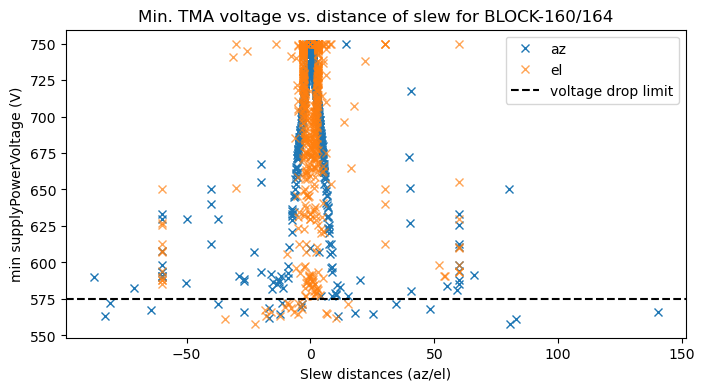

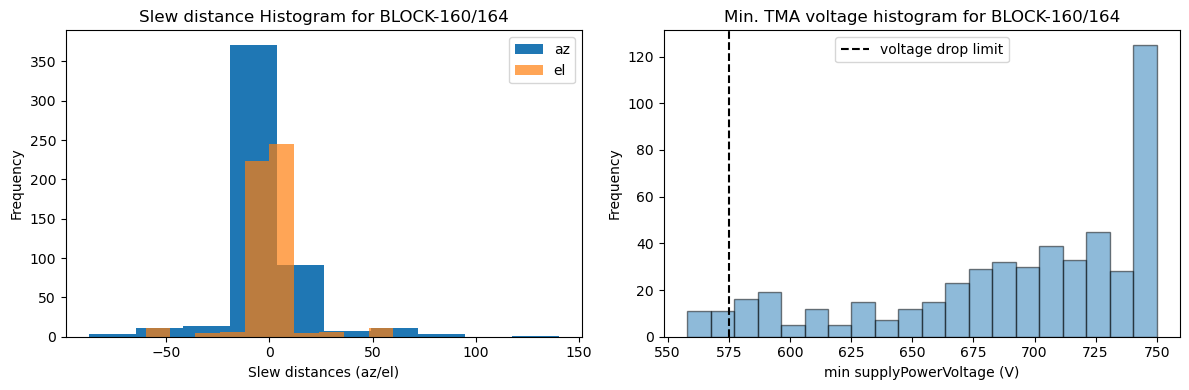

In [202]:
plot_spv_vs_dist(df, 'BLOCK-160/164','tma_perf_dec_2023')

Explore when Az and El moved at same time, rather than separately

In [240]:
def move_az_el(az, el):
    if not az.empty and not el.empty:
        init = az.timestamp.iloc[0] == el.timestamp.iloc[0]
        end = az.timestamp.iloc[-1] == el.timestamp.iloc[-1]
        return init, end
    else:
        # Empty Data
        return False, False



In [244]:
def plot_bar_chart(dayObs, simultaneous_movements, No_simultaneous_movements, init_diffs, end_diffs):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Creamos una figura con dos subtramas

    labels = ['At same time', 'No Simultaneous']
    counts = [len(simultaneous_movements), len(No_simultaneous_movements)]

    axs[0].bar(labels, counts)  # Graficamos en la primera subtrama
    axs[0].set_title(f"Az and El moved at same time for dayObs: {dayObs}")
    axs[0].set_xlabel('Movement Type')
    axs[0].set_ylabel('Count')

    # Filtrar valores None
    init_diffs = [diff for diff in init_diffs if diff is not None]
    end_diffs = [diff for diff in end_diffs if diff is not None]

    axs[1].hist(init_diffs, alpha=0.5, label='Init Difference')
    axs[1].hist(end_diffs, alpha=0.5, label='End Difference')
    axs[1].set_title(f"Time Differences at Slew Start and End for dayObs: {dayObs}")
    axs[1].set_xlabel('Time Difference (s)')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()

    plt.tight_layout()  # Ajustamos el diseño para que no haya superposición de etiquetas
    plt.show()

20231211: Found 528 slews and 449 tracks


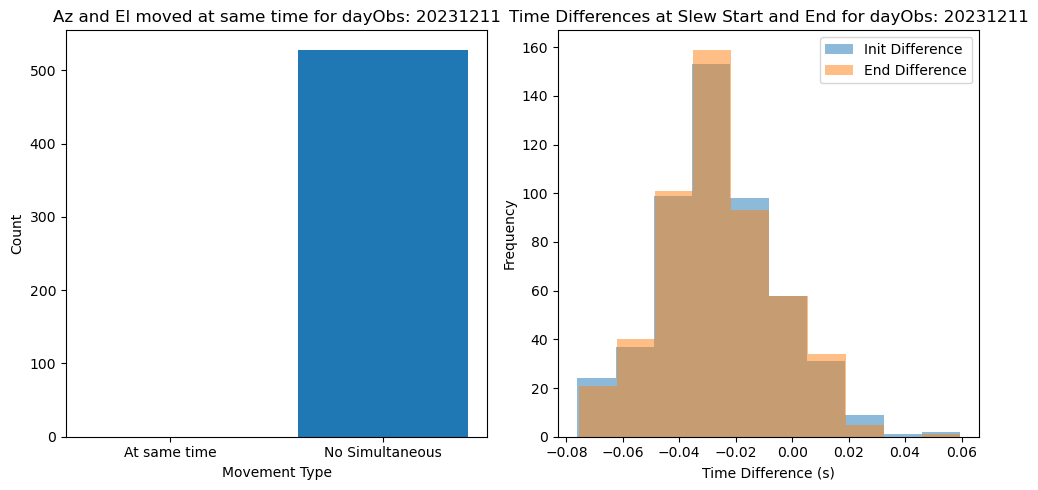

In [245]:
for dayObs in obs_days:
    simultaneous_movements = []
    No_simultaneous_movements = []
    init_diffs = []
    end_diffs = []
    try:
        slews = get_events(dayObs)
    except:
        print(dayObs)
    for i, slew in enumerate(slews):
        az = await client.select_time_series(tma_az_topic, ['*'], slew.begin, slew.end)
        el = await client.select_time_series(tma_el_topic, ['*'], slew.begin, slew.end)
        init, end = move_az_el(az, el)
        if init and end:
            simultaneous_movements.append(i)
        else:
            No_simultaneous_movements.append(i)
            az_diff = az.timestamp.iloc[0] - el.timestamp.iloc[0] if not az.empty and not el.empty else None
            el_diff = az.timestamp.iloc[-1] - el.timestamp.iloc[-1] if not az.empty and not el.empty else None
            init_diffs.append(az_diff)
            end_diffs.append(el_diff)
        
    plot_bar_chart(dayObs, simultaneous_movements, No_simultaneous_movements, init_diffs, end_diffs)


Look at Azimuth acceleration vs. power supply voltage

In [107]:
def plots_spv_vs_az(df_, title_date,name):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(12, 4))

    ax1.plot(df_.az_max_vel, df_.min_power,'x',label='azVel')
    #ax1.plot(df_.el_max_vel, df_.min_power,'x', label='elVel')
    ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    #ax1.set_xlim(-1,12)
    ax1.set_xlabel('max Velocity (m/s)')
    ax1.set_ylabel('min supplyPowerVoltage (V)')

    ax2.plot(df_.az_max_acc, df_.min_power,'x',label='azAcc')
    #ax2.plot(df_.el_max_acc, df_.min_power,'x',label='elAcc')
    ax2.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax2.legend()
    #ax2.set_xlim(-1,25)
    ax2.set_xlabel('max Acceleration $(m/s^{2})$')
    #ax2.set_ylabel('min supplyPowerVoltage (V)')
               
    ax3.plot((df_.az_pos_begin - df_.az_pos_end), df_.min_power,'x',label='azSlewDis')
    #ax3.plot(df_.el_max_jerk, df_.min_power,'x', label='elJerk')
    ax3.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax3.legend()
    #ax3.set_xlim(-100,800)
    ax3.set_xlabel('Slew distances')
    #ax3.set_ylabel('min supplyPowerVoltage (V)')
               
    fig.suptitle(f'Min. TMA voltage vs. TMA Performance for {title_date}')
    fig.tight_layout()
    plt.savefig(f'{name}.png')

In [110]:
def plots_az(df_, title_date,name):
    df_ = df_[(df_.min_power<575)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12, 4))
     
    ax1.plot((df_.az_pos_begin - df_.az_pos_end), df_.min_power,'x',label='azSlewDis for Min. Power < 575V')
    ax1.axhline(575, ls='--', c='k',label='voltage drop limit')
    ax1.legend()
    ax1.set_xlabel('Slew distances')
    ax1.set_ylabel('min supplyPowerVoltage (V)')
    
    bins = np.linspace(-150, +150, 25)
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, alpha=0.5, bins=bins, color='C0')
    ax2.hist(df_.az_pos_begin - df_.az_pos_end, alpha=0.7, bins=bins, label='Min. Power < 575V')  
    ax2.set_xlabel('Slew distances')
    ax2.set_ylabel('Azimuth')

    
    fig.suptitle(f'Min. TMA voltage vs. TMA Performance for {title_date} for min_power<575')
    fig.tight_layout()
    plt.savefig(f'{name}.png')

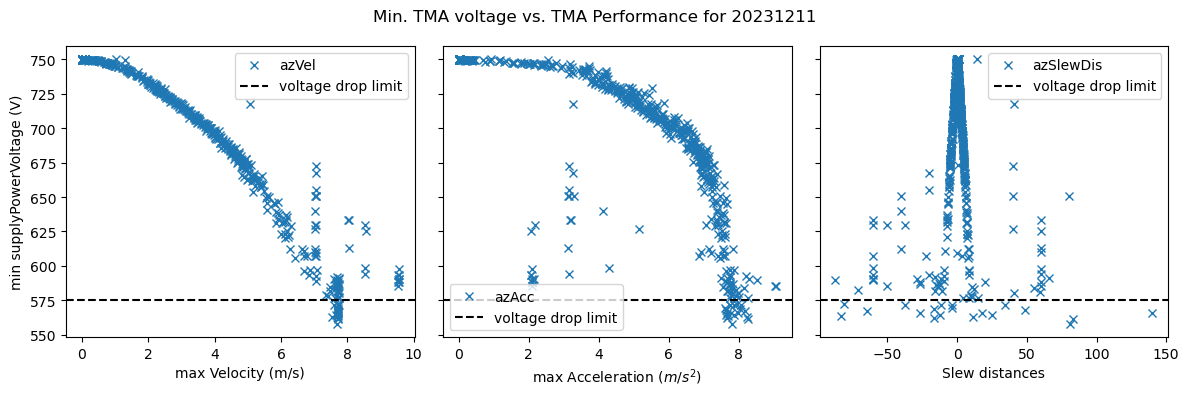

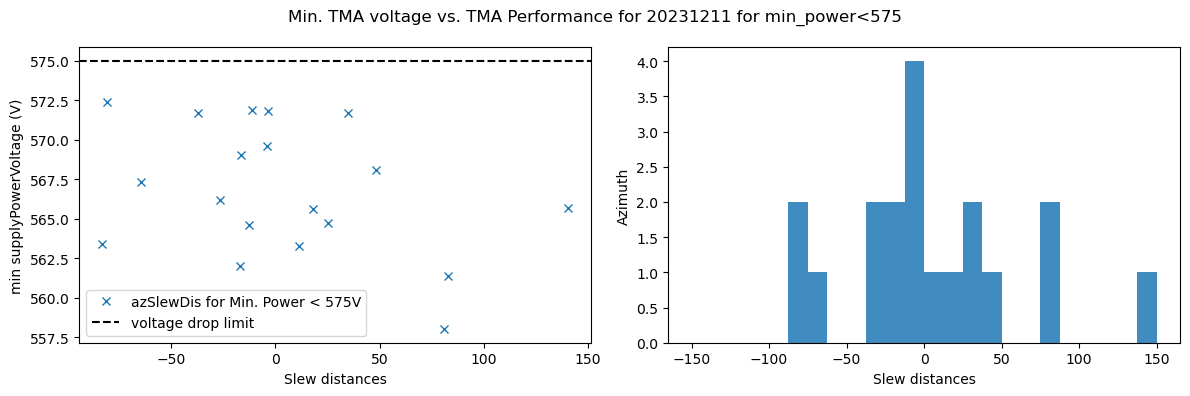

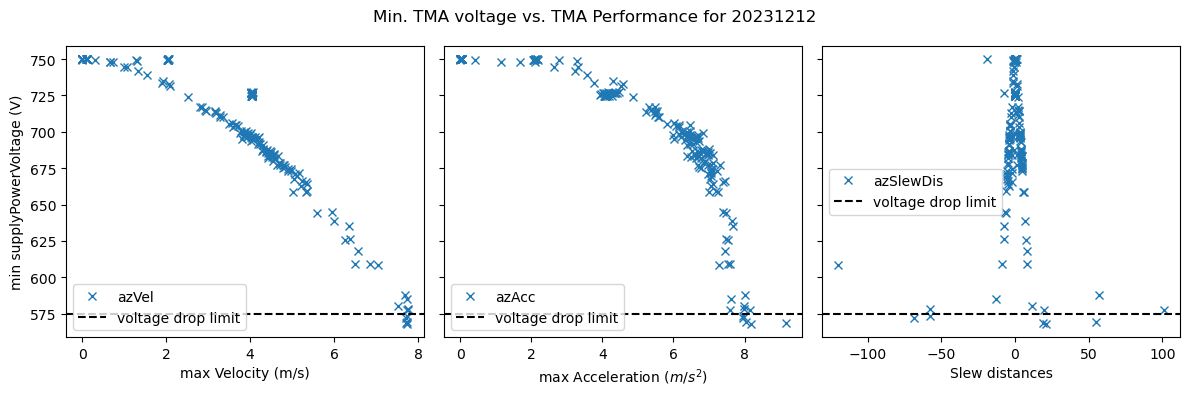

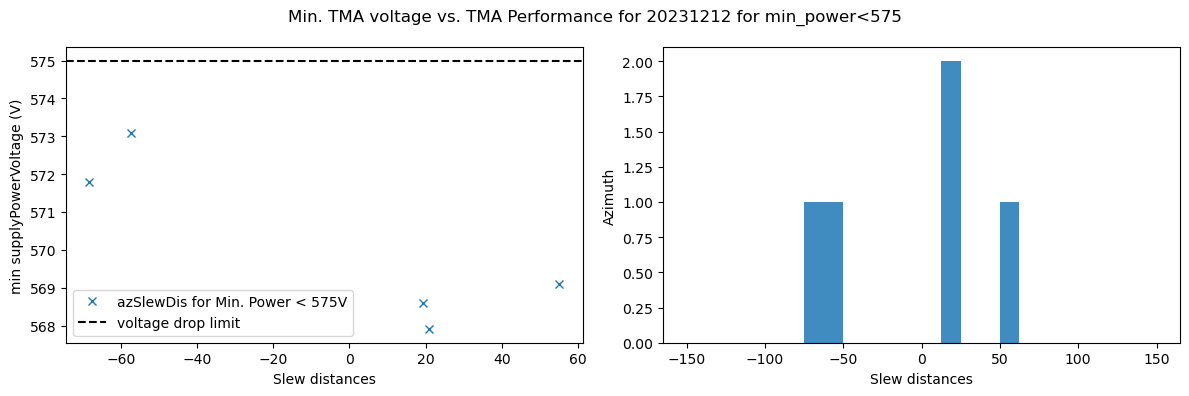

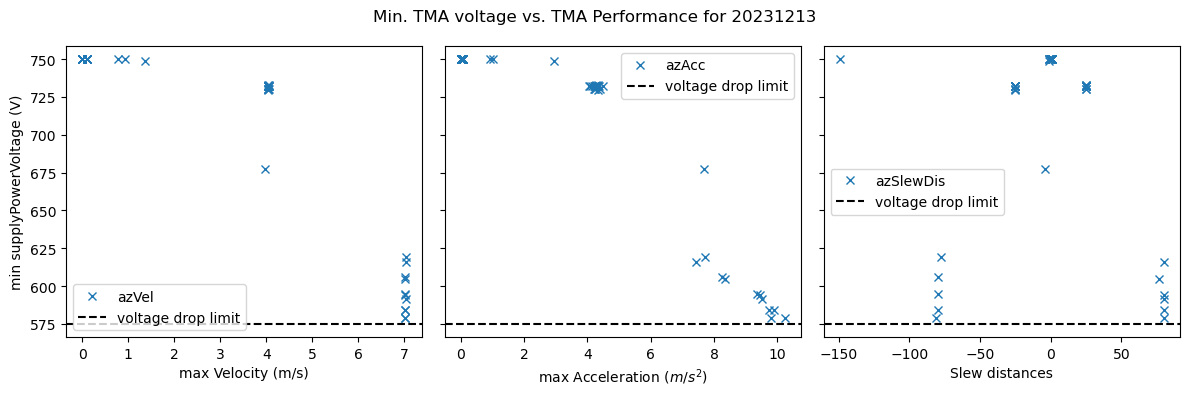

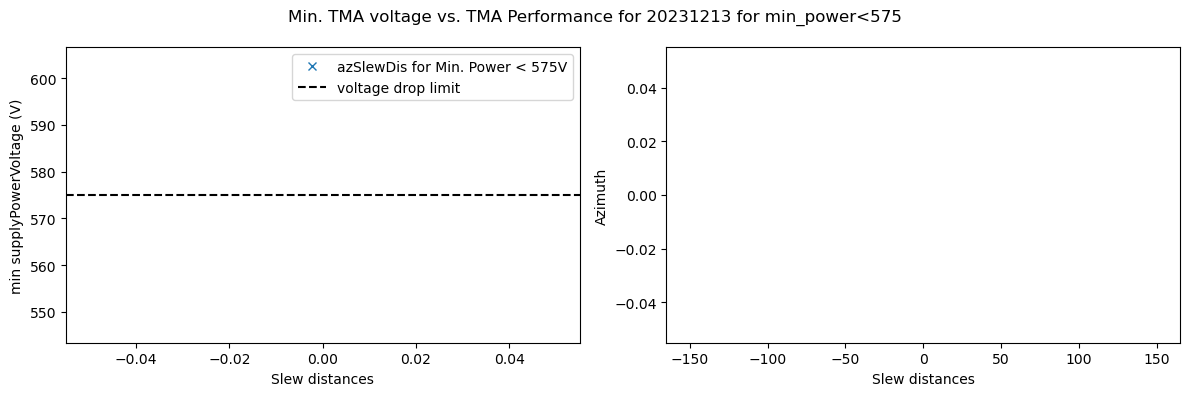

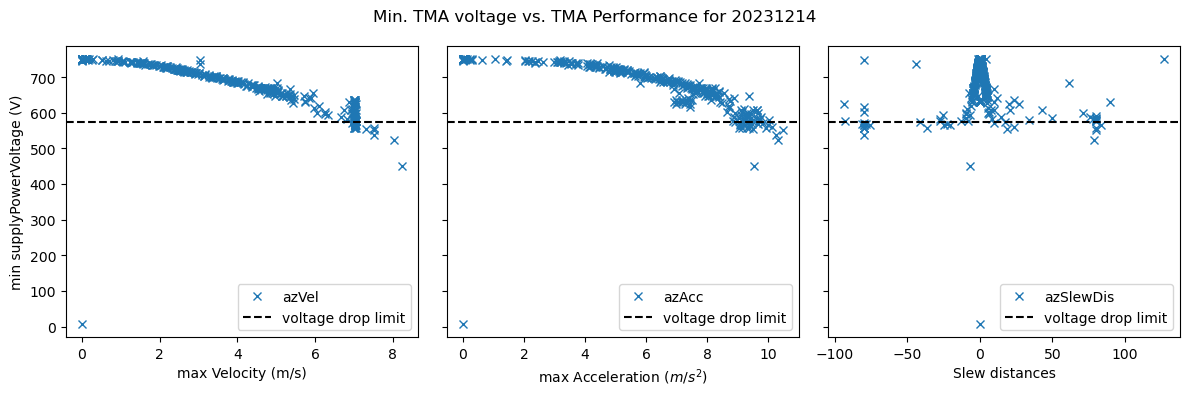

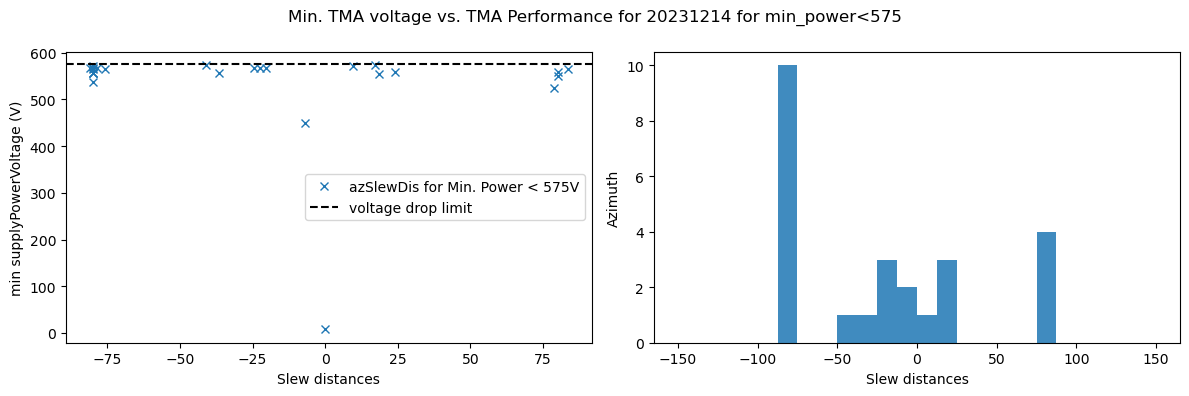

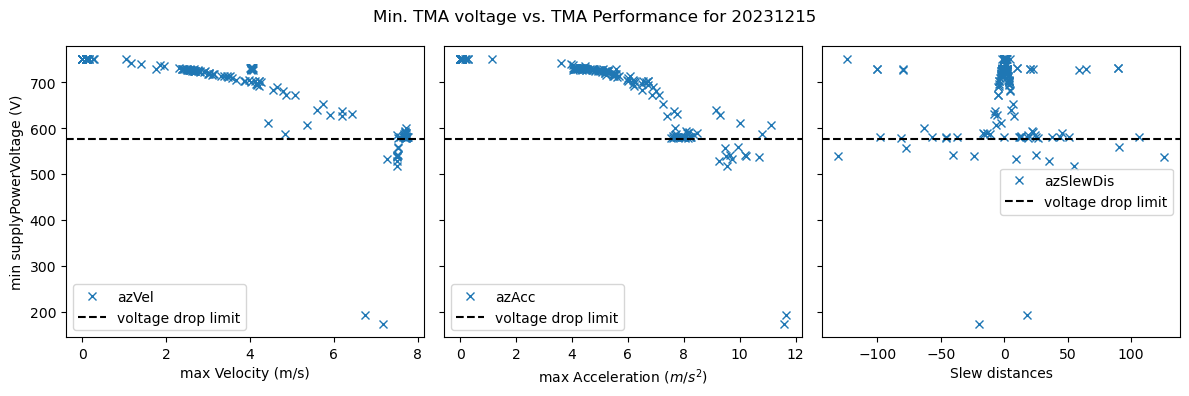

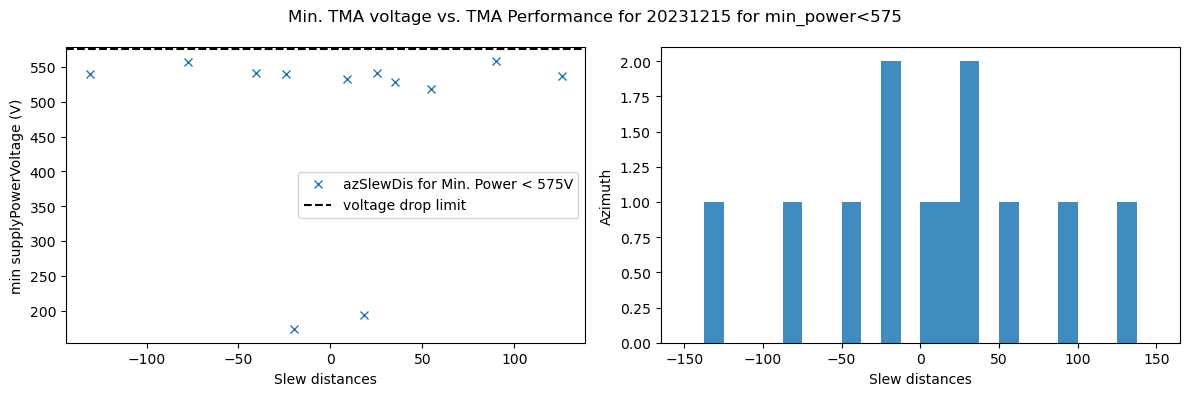

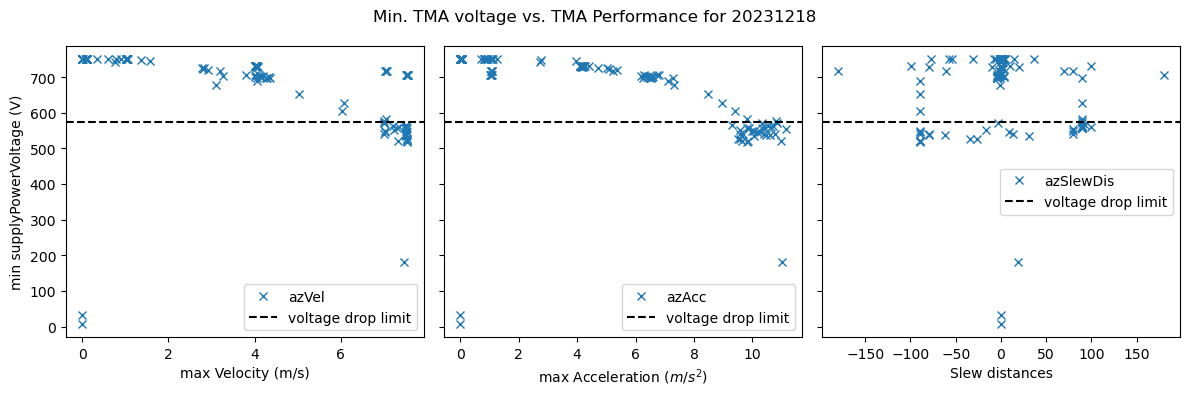

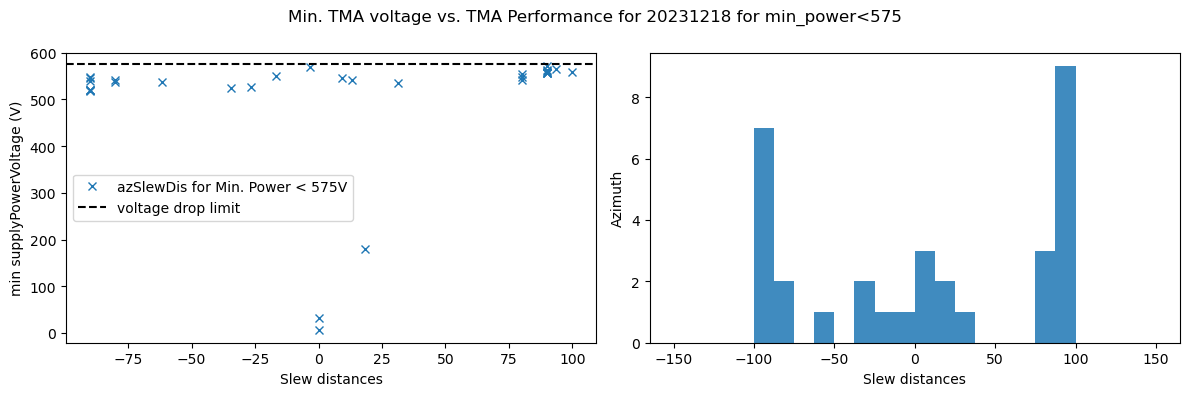

In [111]:
for dayObs in np.unique(df.dayobs):
    df_ = df[df.dayobs == dayObs]
    plots_spv_vs_az(df_, dayObs,f'tma_perf_{dayObs}')
    plots_az(df_, dayObs,f'tma_perf_{dayObs}')